# Physically-Informed Neural Network Solution of the Viscous Burgers PDE with Sinusoidal Initial Condition
 This code is distributed under the GNU LGPL license.<br>
 Last Modified: Apr 9 2022<br>

 Author: Ulisses Braga-Neto <br>
 Professor of Electrical and Computer Engineering<br>
Director of the TAMIDS Scientific Machine Learning Lab<br>
Texas A&M University<br>
https://sciml.tamids.tamu.edu/<br>
https://braganeto.engr.tamu.edu/<br>

This Tensorflow 2.x code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known viscous Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \quad\quad\quad\quad  (1)\\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\\
  \end{aligned}

where $\nu>0$ is the kinematic viscosity (The inverse of the viscosity $R=1/\nu$ is the Reynolds number for this problem.) 

If the viscosity is smaller than about $0.1\pi$, the solution of (1) has a hyperbolic character, and a "shock" forms at $x=0$. Otherwise, there is not enough energy in the initial condition to overcome the viscosity, and the solution has a diffusive character. 

In this demo, the PINN solution of (1) is computed with TensorDiffEq, an open-source package based on TensorFlow 2.x with multi-GPU capabilities (https://arxiv.org/abs/2103.16034) Thanks to Levi McClenny (Texas A&M Electrical and Computer Engineering graduate student) for the Burgers PDE PINN implementation on TensorDiffEq.

For comparison, an accurate approximation of the solution is computed by Gauss-Hermite quadrature (see the "Note" below), based on a program by John Burkardt (https://people.sc.fsu.edu/~jburkardt/py_src/burgers_solution/burgers_solution.py). 

The PINN approximation matches the quadrature solution quite well and takes less time to compute (even though the quadrature is working with an analytical solution, while the PINN is agnostic to it). Both approximations becomes unstable if the viscosity is smaller than about $0.005/\pi$. Trying different values of $\nu$ and inspecting the resulting evolution is instructive.

The code produces a video animation of the temporal evolution of the two superimposed solutions. The animation code is based on similar code by Durward Cator III (Texas A&M Electrical and Computer Engineering undergraduate student). Thanks also to Emílio Coutinho (Texas A&M Petroleum Engineering graduate student) for suggestions on improving the apperance of the text.

Note: The quadrature approximation is based on the fact that, for large enough $R$, (1) is an approximation of the inviscid Burgers problem ($\nu = 0$), in which case it can be proved using the method of characteristics that any zero value in the initial condition stays constant at zero throughout the solution. Therefore, (1) is approximately equal to the initial-value problem (IVP):
\begin{aligned}
  &\hat{u}_t + \hat{u}\hat{u}_x = \nu \hat{u}_{xx}\,, \quad (x,t) \in R \times [0,\infty)\,,\\
    & \hat{u}(x,0) = \begin{cases} -\sin(\pi x)\,,& -1 < x < 1\,,\\
    0\,, & |x|>1\,. \end{cases} \quad\quad\quad\quad  (2)\\
  \end{aligned}
The Cole-Hopf transform [1] provides a closed-form solution to the IVP (2):

$$\hat{u}(x,t) = -\frac{\int_{-\infty}^\infty \sin(\pi(x-z))\exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}
{\int_{-\infty}^\infty \exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}\,.$$

For sufficiently small $t$, we have $u(x,t) \approx \hat{u}(x,t)$, for $x \in [-1,1]$. In [2], it is claimed that Gauss-Hermite quadrature produced a seven-digit accurate result for $u_x(0,t)$ up to $t = 3/\pi$ with a viscosity $\nu = 0.01/\pi$. 

References:

[1]  E. Hopf, The partial differential equation $u_t + uu_x = \mu u_{xx}$. Comm. Pure Appl. Math. 3, 201-230, 1950.

[2] Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
  J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
  Spectral and finite difference solutions of the Burgers equation,
  Computers and Fluids,   Volume 14, Number 1, 1986, pages 23-41.

In [ ]:
"""
Problem Definition and Quadrature Solution
"""

import numpy as np
from numpy.polynomial.hermite import hermgauss

nu = 0.01/np.pi # viscosity parameter

# define grid for quadrature solution
utn = 128
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 5.0/np.pi
ut = np.linspace (tlo,thi,utn)

qn = 64 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn])
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

In [ ]:
"""
PINN solution using TensorDiffEq
"""

!pip -q install tensordiffeq

import math
import scipy.io
import tensordiffeq as tdq
from tensordiffeq.boundaries import *
from tensordiffeq.models import CollocationSolverND

def f_model(u_model, x, t):
    u = u_model(tf.concat([x,t],1))
    u_x = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x,x)[0]
    u_t = tf.gradients(u,t)[0]
    f_u = u_t + u * u_x - nu*u_xx
    return f_u

def func_ic(x):
    return -np.sin(x*np.pi) 

Domain = DomainND(["x","t"],time_var='t')
Domain.add("x",[-1.0,1.0],uxn)
Domain.add("t",[0.0,5.0/np.pi],utn)

init = IC(Domain,[func_ic],var=[['x']])
upper_x = dirichletBC(Domain,val=0.0,var='x',target="upper")
lower_x = dirichletBC(Domain,val=0.0,var='x',target="lower")
BCs = [init,upper_x,lower_x]

N_f = 10000
Domain.generate_collocation_points(N_f)

layer_sizes = [2,20,20,20,20,20,20,20,20,1]

model = CollocationSolverND()
model.compile(layer_sizes,f_model,Domain,BCs,isAdaptive=False) 
"""
Code for Self-Adaptive PINN:
col_weights = tf.Variable(tf.random.uniform([N_f,1]),trainable=True,dtype=tf.float32)
u_weights = tf.Variable(100*tf.random.uniform([uxn,1]),trainable=True,dtype=tf.float32)
model.compile(layer_sizes,f_model,Domain,BCs,isAdaptive=True,col_weights=col_weights,u_weights=u_weights)
"""
model.fit(tf_iter=2000,newton_iter=0)

# apply PINN to the same grid as the quadrature solution for comparison
x = Domain.domaindict[0]['xlinspace']
t = Domain.domaindict[1]["tlinspace"]
X,T = np.meshgrid(x,t)
X_flat = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_PINN,_ = model.predict(X_flat)

     |████████████████████████████████| 865 kB 10.9 MB/s 
     |████████████████████████████████| 462 kB 59.3 MB/s 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


  ______                           ____  _ ______________     
 /_  __/__  ____  _________  _____/ __ \(_) __/ __/ ____/___ _
  / / / _ \/ __ \/ ___/ __ \/ ___/ / / / / /_/ /_/ __/ / __ `/
 / / /  __/ / / (__  ) /_/ / /  / /_/ / / __/ __/ /___/ /_/ / 
/_/  \___/_/ /_/____/\____/_/  /_____/_/_/ /_/ /_____/\__, /  
                                                        /_/   

Neural Network Model Summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)    

  0%|          | 0/2000 [00:00<?, ?it/s]

nu = 0.01/pi
L2 Error = 3.403326e-02


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

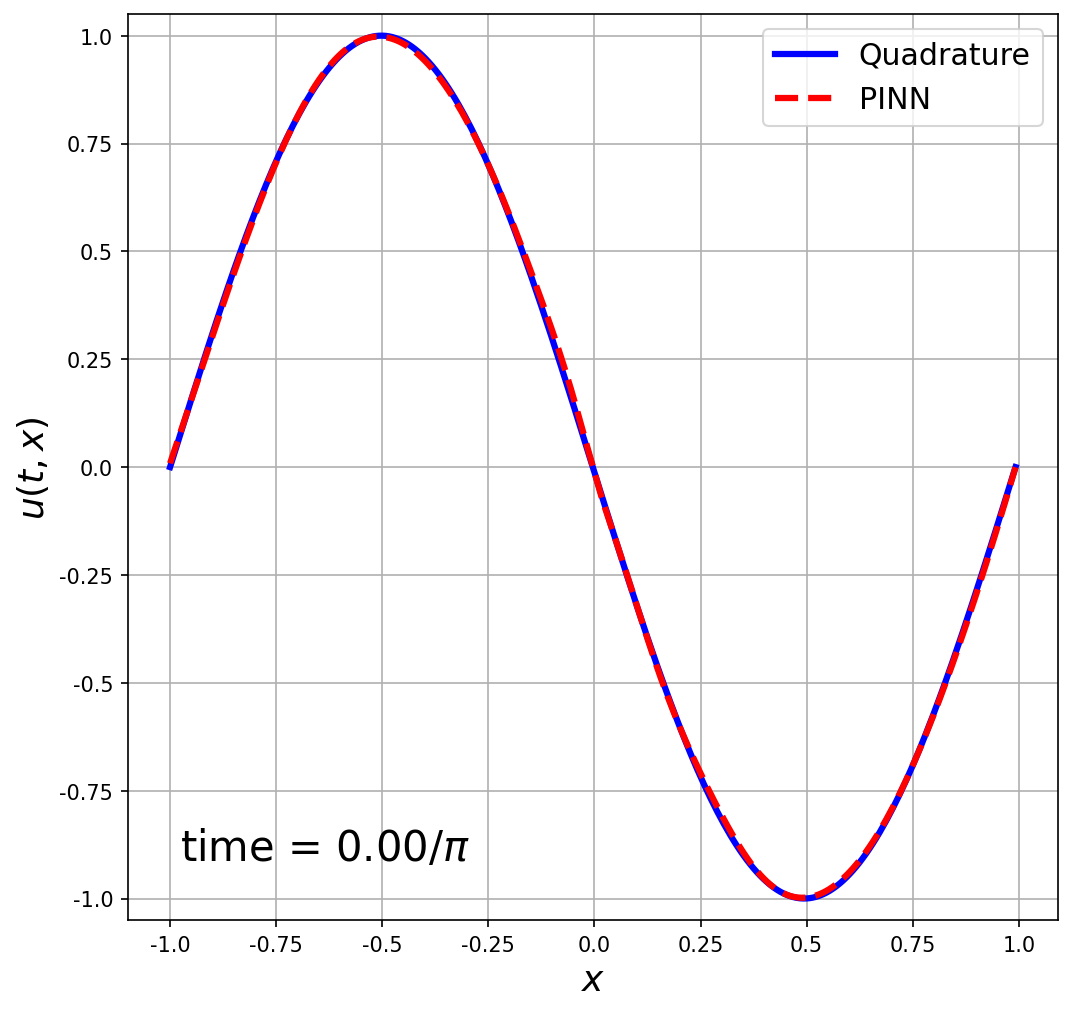

In [ ]:
"""
Comparison and Animation
"""

from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.animation as animation

error_u = tdq.helpers.find_L2_error(u_PINN,u_quad.T.flatten()[:,None])
print('nu = %.2f/pi' % (np.pi*nu))
print('L2 Error = %e' % (error_u))

time_steps = utn # total number of time steps in animation
fps = 15 # frames/second of animation

def snapshot(i):
    plt.clf()
    plt.ylim([-1.05,1.05])
    plt.plot(u_quad[:,i],'b-',linewidth=3,label='Quadrature') 
    plt.plot(u_PINN[i*uxn:(i+1)*uxn],'r--',linewidth=3,label='PINN')       
    locs,labels = plt.xticks()
    plt.xticks(np.linspace(0,uxn,9),\
               np.round(ux[np.linspace(0,uxn-1,9).astype(int)]+0.005,2).astype('str'))
    plt.yticks(np.linspace(-1.0,1.0,9),np.round(np.linspace(-1,1,9),2).astype('str'))
    plt.xlabel('$x$',fontsize='xx-large')
    plt.ylabel('$u(t,x)$',fontsize='xx-large')
    plt.text(3,-0.91,r'time = {:.2f}/$\pi$'.format(np.pi*i*thi/(utn-1)),fontsize=20)
    plt.grid()
    plt.legend(fontsize='x-large')

fig = plt.figure(figsize=(8,8),dpi=150)
# Call the animator:
anim = animation.FuncAnimation(fig,snapshot,frames=time_steps)
# Save the animation as an mp4. This requires ffmpeg to be installed.
anim.save('Burgers_Demo.mp4',fps=fps)
files.download('Burgers_Demo.mp4')